In [1]:
# Libraries
# ======================================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
import skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
warnings.filterwarnings('once')

print(f"Version skforecasy: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")

Version skforecasy: 0.12.1
Version scikit-learn: 1.3.0


In [264]:
survey_file = '/Users/htr365/Documents/Side_Projects/09_founding_lab/amanda_johanna/quantified_self.nosync/pipeline/survey_data/pre_processed_survey_features.csv'
data = pd.read_csv(survey_file,index_col=0)

In [265]:
# filter a person
data = data[data['person']=='Amanda']
data.index = data['date']
data_all = data

In [266]:
data = data[data['date']>='2024-07-08']
data = data[data['date']<'2024-07-21']

In [254]:
data.columns

Index(['person', 'date', 'cis_1', 'cis_2', 'cis_3', 'cis_4', 'cis_5', 'cis_6',
       'cis_7', 'cis_8', 'cis_9', 'cis_10', 'cis_11', 'cis_12', 'cis_13',
       'cis_14', 'cis_15', 'cis_16', 'cis_17', 'cis_18', 'cis_19', 'cis_20',
       'hooper_muscles_sore', 'extra_muscles_tired', 'hooper_sleep_quality',
       'hooper_fatigue_level', 'hooper_stress_level', 'sleep_hours',
       'coffee_count', 'physical_activity', 'step_count', 'alcohol',
       'fatigue_expected', 'muscles_sore_expected', 'muscles_tired_expected',
       'cis_subjective_fatigue', 'cis_concentration', 'cis_motivation',
       'cis_physical_activity', 'sleep_time', 'walking', 'cycling',
       'ball_sports', 'weight_lifting', 'running', 'yoga', 'spinning',
       'cis_subjective_fatigue_lead1', 'hooper_fatigue_level_lead1'],
      dtype='object')

In [267]:
human_prediction = data[['fatigue_expected','muscles_sore_expected','muscles_tired_expected']]
variables_of_interest = ['cis_subjective_fatigue','cis_concentration','cis_motivation','cis_physical_activity',
                         'hooper_fatigue_level','hooper_stress_level', 'hooper_muscles_sore','hooper_sleep_quality',
                         'extra_muscles_tired','step_count','sleep_time','alcohol']

In [268]:
data.index = pd.DatetimeIndex(data.index)
data.index.freq = 'D'

In [257]:
data = data.interpolate()

In [269]:
# Split data into train-validation-test
# ======================================================================================
end_train = data.index[int(np.floor(len(data.index)*0.8))]
end_val = data.index[int(np.floor(len(data.index)*0.9))]


data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2024-07-08 00:00:00 --- 2024-07-17 00:00:00  (n=10)
Validation dates : 2024-07-17 00:00:00 --- 2024-07-18 00:00:00  (n=2)
Test dates       : 2024-07-18 00:00:00 --- 2024-07-19 00:00:00  (n=2)


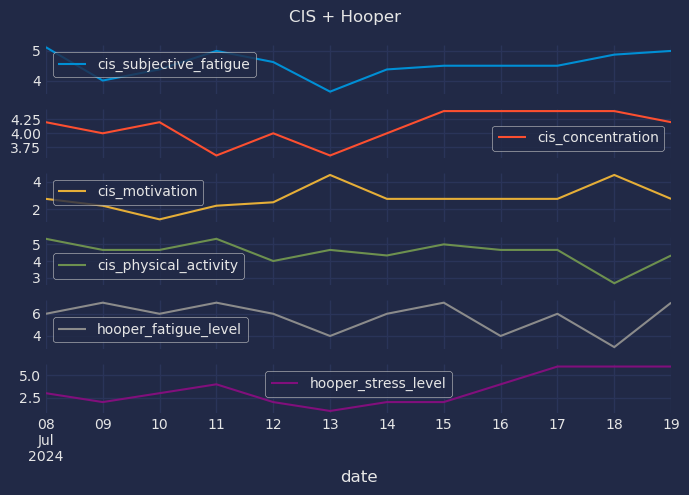

In [270]:
# Plot time series
# ======================================================================================
set_dark_theme()
fig, axs = plt.subplots(6, 1, figsize=(7, 5), sharex=True)
data[['cis_subjective_fatigue','cis_concentration','cis_motivation','cis_physical_activity','hooper_fatigue_level','hooper_stress_level']].plot(
    legend   = True,
    subplots = True, 
    title    = 'CIS + Hooper',
    ax       = axs, 
)
#for ax in axs:
  #  ax.axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1.5)
  #  ax.axvline(pd.to_datetime(end_val ), color='white', linestyle='--', linewidth=1.5)
fig.tight_layout()
plt.show()

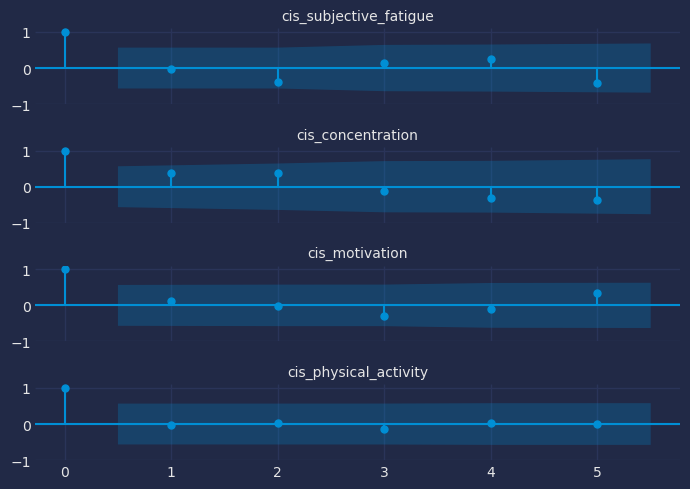

In [271]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 5), sharex=True)
axes = axes.flat
for i, col in enumerate(data[['cis_subjective_fatigue','cis_concentration','cis_motivation','cis_physical_activity']]):
    plot_acf(data[col], ax=axes[i], lags=5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}', fontsize=10)
fig.tight_layout()
plt.show()

In [272]:
data= data[variables_of_interest]

In [303]:
from sklearn.ensemble import RandomForestRegressor

items = []
rf_mse_values = []
rf_predictions = {}
# Backtest forecaster
# ==============================================================================
forecaster_random_forest = ForecasterAutoreg(
                  regressor = RandomForestRegressor(random_state=123),
                  lags      = 5 
             )
for i, item in enumerate(data.columns):
     print(item)
     rf_metric, rf_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_random_forest,
                                        y          = data[item],
                                        initial_train_size = len(data.loc[:end_train]),
                                        fixed_train_size   = False,
                                        steps      = 5,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = True
                                   )
     items.append(item)
     rf_mse_values.append(rf_metric)
     rf_predictions[item] = rf_predictions_backtest

# Results
rf_uni_series_mse = pd.Series(
                     data  = rf_mse_values,
                     index = items,
                     name  = 'uni_series_mse'
                 )

cis_subjective_fatigue
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

cis_concentration
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

cis_motivation
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

cis_physical_activity
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

hooper_fatigue_level
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

hooper_stress_level
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

hooper_muscles_sore
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

hooper_sleep_quality
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

extra_muscles_tired
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

step_count
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

sleep_time
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

alcohol
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

In [304]:
items = []
gb_mse_values = []
gb_predictions = {}
# Define forecaster
forecaster_gradient_boost = ForecasterAutoreg(
                    regressor     = HistGradientBoostingRegressor(random_state=8523),
                    lags          = 5,
                    transformer_y = StandardScaler()
                 )
for i, item in enumerate(tqdm(data.columns)):

     gb_metric, gb_predictions_backtest = backtesting_forecaster(
                                        forecaster = forecaster_gradient_boost,
                                        y          = data[item],
                                        initial_train_size = len(data.loc[:end_train]),
                                        fixed_train_size   = False,
                                        steps      = 10,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = True
                                   )

     items.append(item)
     gb_mse_values.append(gb_metric)
     gb_predictions[item] = gb_predictions_backtest

# Results
gb_uni_series_mse = pd.Series(
                     data  = gb_mse_values,
                     index = items,
                     name  = 'gb_uni_series_mse')

/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10
Number of observations used for backtesting: 2
    Number of folds: 1
    Number of steps per fold: 10
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2024-07-08 00:00:00 -- 2024-07-17 00:00:00  (n=10)
    Validation: 2024-07-18 00:00:00 -- 2024-07-19 00:00:00  (n=2)



/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

In [311]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(data.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=8523),
                    lags               = 5,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
gb_multi_series_mse, gb_predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data.loc[:end_train]),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(gb_multi_series_mse.head(3))
print('')
display(gb_predictions_ms.head(3))


/Users/htr365/opt/anaconda3/envs/muscles/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,cis_subjective_fatigue,0.442363
1,cis_concentration,0.368189
2,cis_motivation,1.274455


,cis_subjective_fatigue,cis_concentration,cis_motivation,cis_physical_activity,hooper_fatigue_level,hooper_stress_level,hooper_muscles_sore,hooper_sleep_quality,extra_muscles_tired,step_count,sleep_time,alcohol
2024-07-18,4.555111,3.969714,2.269839,4.899315,6.220560,3.962259,5.862000,4.895993,5.777693,5310.862400,441.454963,0.504985
2024-07-19,4.435163,3.893908,2.431251,4.842325,5.966156,3.536666,5.376344,4.976728,5.292037,6416.448639,448.088048,1.128130


In [312]:
# Difference of backtesting metric for each item
# ======================================================================================
gb_multi_series_mse = gb_multi_series_mse.set_index('levels')
gb_multi_series_mse.columns = ['multi_series_mse']


In [314]:

results = pd.concat((gb_uni_series_mse, rf_uni_series_mse, gb_multi_series_mse), axis = 1)
results['improvement'] = results.eval('gb_uni_series_mse - multi_series_mse')
results['improvement_(%)'] = 100 * results.eval('(gb_uni_series_mse - multi_series_mse) / gb_uni_series_mse')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d'])

,gb_uni_series_mse,uni_series_mse,multi_series_mse,improvement,improvement_(%)
cis_subjective_fatigue,0.640000,0.480000,0.440000,0.200000,30.610000
cis_concentration,0.140000,0.360000,0.370000,-0.230000,-162.990000
cis_motivation,0.880000,0.880000,1.270000,-0.400000,-45.650000
cis_physical_activity,1.170000,1.160000,1.370000,-0.200000,-17.500000
hooper_fatigue_level,2.000000,2.670000,2.130000,-0.130000,-6.360000
hooper_stress_level,3.000000,3.060000,2.250000,0.750000,24.980000
hooper_muscles_sore,1.000000,0.750000,1.240000,-0.240000,-24.280000
hooper_sleep_quality,1.200000,0.440000,0.940000,0.260000,21.970000
extra_muscles_tired,1.500000,1.250000,1.740000,-0.240000,-16.190000
step_count,4239.000000,4845.380000,4791.790000,-552.790000,-13.040000


In [315]:

def pred_to_df(predictions):
    combined_df= pd.DataFrame()

    # Loop through each key, value pair in the dictionary
    for key, df in predictions.items():
        # Rename the 'pred' column to the key value
        df = df.rename(columns={'pred': key})
        # Concatenate along columns
        if combined_df.empty:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df], axis=1)
    return combined_df

In [317]:
rf_test_pred = pred_to_df(rf_predictions)
gb_test_pred = pred_to_df(gb_predictions)

In [ ]:
var_outcome = ['cis_subjective_fatigue','hooper_fatigue_level','extra_muscles_tired','hooper_muscles_sore']
human_pred = ['fatigue_expected','muscles_sore_expected','muscles_tired_expected']

In [349]:
dict_human = {'cis_subjective_fatigue':'fatigue_expected',
              'hooper_fatigue_level':'fatigue_expected',
              'extra_muscles_tired':'muscles_tired_expected',
              'hooper_muscles_sore':'muscles_sore_expected'}

'fatigue_expected'

In [353]:
data_test[dict_human.get(var_outcome)]

date
2024-07-18    7.0
2024-07-19    5.0
Freq: D, Name: fatigue_expected, dtype: float64

In [347]:
rf_test_pred[var_outcome].rename('rf_'+var_outcome)

2024-07-18    4.45250
2024-07-19    4.46875
Freq: D, Name: rf_cis_subjective_fatigue, dtype: float64

In [364]:
results = pd.concat([rf_test_pred[var_outcome].rename('rf_'+var_outcome),
gb_test_pred[var_outcome].rename('gb_'+var_outcome),
data_test[dict_human.get(var_outcome)].rename('h_'+var_outcome)],
axis=1)

results_diff = data_test[var_outcome]-results
results

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-18,4.45250,4.3,7.0
2024-07-19,4.46875,4.3,5.0


In [374]:
np.abs(data_test[var_outcome] - results.transpose()).transpose()

,rf_cis_subjective_fatigue,gb_cis_subjective_fatigue,h_cis_subjective_fatigue
2024-07-18,0.42250,0.575,2.125
2024-07-19,0.53125,0.700,0.000
